In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch

sys.path.append(os.path.join(os.getenv("HOME"), "RNN_Manifold/"))
from manifold_encoder_decoder import s1_direct_product_decoder, geometry_util


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using {}".format(device))

using cuda


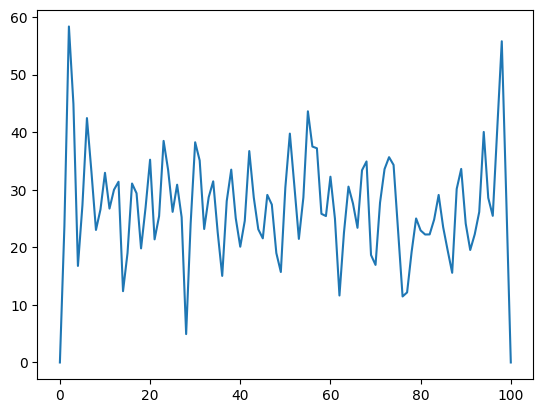

In [44]:
def generate_manifold_data(base_grid, rolls, size):
    axs = np.arange(start=0, stop=base_grid.ndim, step=1)
    data = []
    for roll in rolls:
        data.append(np.roll(base_grid, roll, axs)[tuple(slice(0, size, 1) for _ in range(base_grid.ndim))])
    return np.array(data)

noise_line = np.random.normal(0, 1, (100))
rolls = np.arange(start=0, stop=101, step=1)
line_phases = rolls/len(noise_line) * 2 * np.pi
ring_data = generate_manifold_data(noise_line, rolls, 10)
distances = np.sum(np.square(ring_data - ring_data[0]), axis=-1)

fig, axs = plt.subplots()
axs.plot(distances)

In [31]:
%matplotlib tk
embedding_dim = 10
n_coeffs = 20
random_ring_fourier = np.zeros((1000, embedding_dim))
random_ring_fourier[1:n_coeffs+1, :] = np.random.normal(0, 1, (n_coeffs, embedding_dim))
random_ring = np.real_if_close(np.fft.irfft(random_ring_fourier, axis=0))
random_ring = random_ring/np.mean(np.abs(random_ring))
fig, axs = plt.subplots()
axs.imshow(random_ring, aspect="auto")

distances = np.sum(np.square(random_ring - random_ring[0]), axis=-1)

fig, axs = plt.subplots()
axs.plot(distances)



In [45]:
ring_encoder, ring_decoder = s1_direct_product_decoder.train(data=ring_data, manifold_dim=1, device=device,
                                                   n_training_iterations=3000, decoder_weight=10, order_red_weight=1)


/home/trevor/brainvenv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


iteration: 0, decoding loss: 1.0183377265930176, distance cost: 0.013908760622143745, order reduction: 0.03872965648770332
iteration: 2, decoding loss: 0.9605458974838257, distance cost: 0.13395416736602783, order reduction: 0.07538142800331116
iteration: 6, decoding loss: 0.9483911991119385, distance cost: 0.005030314903706312, order reduction: 0.0740276500582695
iteration: 7, decoding loss: 0.8894941210746765, distance cost: 0.009237110614776611, order reduction: 0.038417696952819824
iteration: 8, decoding loss: 0.8497909903526306, distance cost: 0.031475991010665894, order reduction: 0.03847862035036087
iteration: 13, decoding loss: 0.8297035694122314, distance cost: 0.02797933667898178, order reduction: 0.07471363991498947
iteration: 14, decoding loss: 0.8108572959899902, distance cost: 0.01816282793879509, order reduction: 0.11071991175413132
iteration: 24, decoding loss: 0.8120043873786926, distance cost: 0.025724053382873535, order reduction: 0.03845026716589928
iteration: 38, d

In [46]:
with torch.no_grad():
    decoded_points, decoded_angles = ring_decoder(torch.tensor(random_ring, dtype=torch.get_default_dtype()).to(device))

predicted_phases = torch.squeeze(decoded_angles).cpu().numpy()


In [47]:
def reference_phases(phases):
    phases_refd = phases - phases[0]
    phases_refd = np.arctan2(np.sin(phases_refd), np.cos(phases_refd))
    return phases_refd * np.sign(phases_refd[1])

In [48]:
def compare_to_ground_truth(predicted_phases, ground_truth_phases, plot_ax):
    refd_test_phases = reference_phases(predicted_phases)
    refd_true_phases = reference_phases(ground_truth_phases)
    line = np.arange(start=-np.pi, stop=np.pi, step=0.01)
    plot_ax.scatter(refd_true_phases, refd_test_phases)
    plot_ax.plot(line, line, color="black", linestyle="--", label="y=x")
    plot_ax.set_xlabel("True Phase")
    plot_ax.set_ylabel("Found Phase")
    return refd_test_phases, refd_true_phases

ValueError: x and y must be the same size

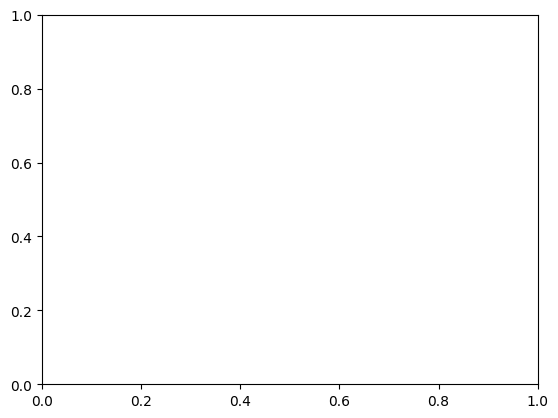

In [50]:
%matplotlib inline
fig, ax = plt.subplots()
refd_predicted_phases, refd_true_phases = compare_to_ground_truth(predicted_phases, line_phases, ax)
